In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
import scipy.linalg as la
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

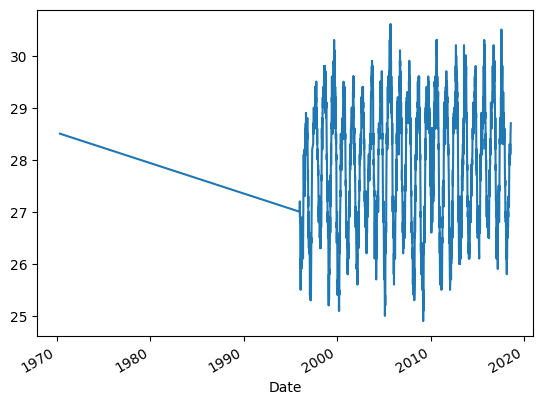

In [2]:
temperature = pd.read_csv('new_temp.csv')
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature.set_index('Date', inplace=True)
temperature['Temp'].values
temperature = temperature.convert_dtypes(convert_floating=True)
temperature['Temp'] = temperature['Temp'].replace('nd', pd.NA).astype(float)
nan_rows = temperature[temperature['Temp'].isna()].index

# Forward fill NaN values
temperature_forward = temperature.fillna(method='ffill')

#backward fill NaN values
temperature_backward = temperature.fillna(method='bfill')

# Take the average of forward filled and backward filled DataFrames
temperature = (temperature_forward + temperature_backward) / 2





temperature['Temp'].plot()
plt.show()





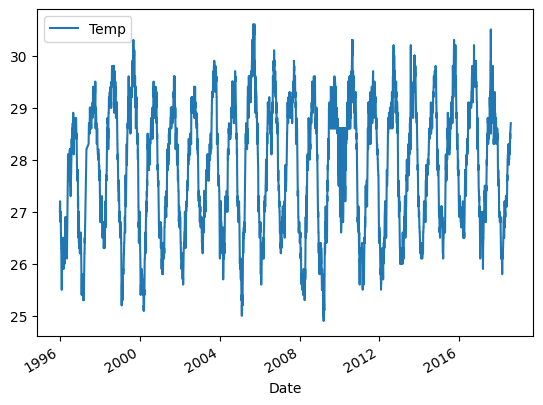

In [3]:
temperature_truncate = temperature.sort_index().truncate(before = '1995-01-01')
# trends = seasonal_decompose(temperature['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()
temperature_truncate.plot()
plt.show()

/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_16432/3739817702.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]


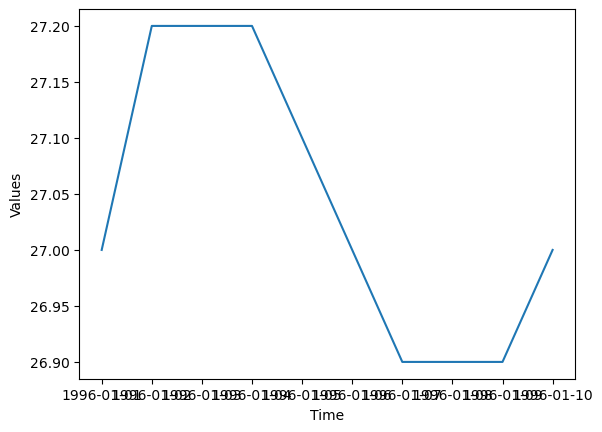

In [5]:
start_day = pd.to_datetime('1996-01-01')
end_day = pd.to_datetime('1996-01-10')

a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]

# Plot the data
plt.plot(a_few_days.index, a_few_days.values)  # Plotting time against values
plt.xlabel('Time')
plt.ylabel('Values')
#plt.title('Data for {}'.format(start_day, end_day))
plt.show()

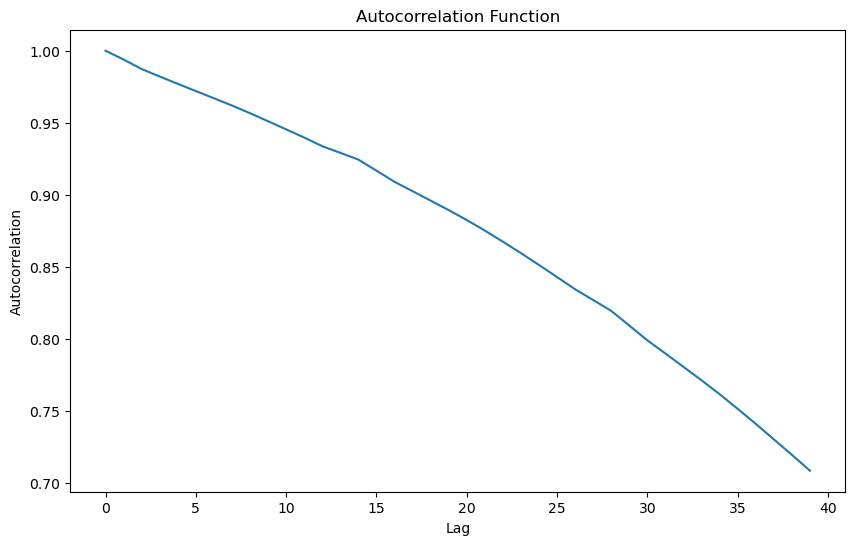

In [6]:
auto_corr = acf(temperature['Temp'])
auto_corr

plt.figure(figsize=(10, 6))
plt.plot(auto_corr)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


In [5]:
temperature_truncate['Temp']

Date
1996-01-01    27.0
1996-01-02    27.2
1996-01-03    27.2
1996-01-04    27.2
1996-01-05    27.1
              ... 
2018-07-21    28.4
2018-07-22    28.5
2018-07-30    28.7
2018-07-31    28.7
2018-08-01    28.7
Name: Temp, Length: 8102, dtype: float64

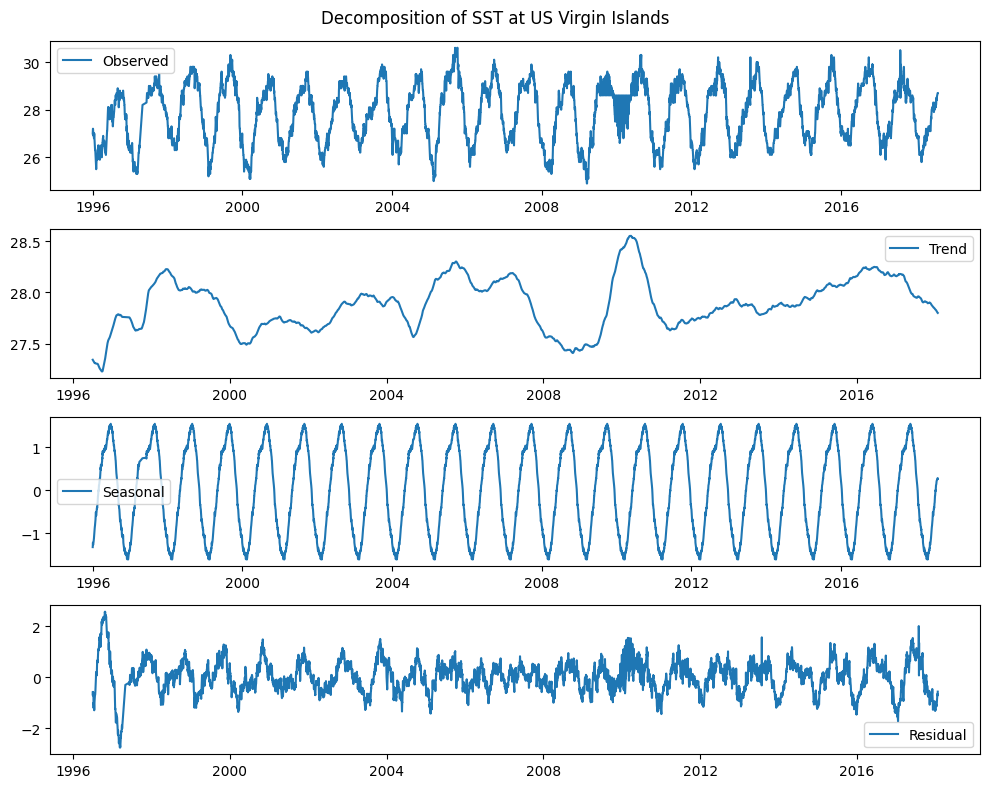

In [19]:
trends = seasonal_decompose(temperature_truncate['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
#plt.plot(trend_predicted, label='Regression Line', linestyle='--')
plt.plot(trends.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual')
plt.legend()

plt.suptitle('Decomposition of SST at US Virgin Islands')
plt.tight_layout()
plt.savefig('water_temp_decomp.png')

plt.show()

In [20]:
trends.observed

Date
1996-01-01    27.0
1996-01-02    27.2
1996-01-03    27.2
1996-01-04    27.2
1996-01-05    27.1
              ... 
2018-07-21    28.4
2018-07-22    28.5
2018-07-30    28.7
2018-07-31    28.7
2018-08-01    28.7
Name: Temp, Length: 8102, dtype: float64

In [15]:
#calculate the moving average
move_average = temperature_truncate.rolling(window = 365).mean()[364:]
move_average

,Temp
Date,
1996-12-30,27.342740
1996-12-31,27.340822
1997-01-01,27.338082
1997-01-02,27.335616
1997-01-03,27.333425
...,...
2018-07-21,27.803014
2018-07-22,27.801644
2018-07-30,27.800548


In [16]:
#calculate the detrended time series
detrend = temperature_truncate[364:] - move_average
detrend

,Temp
Date,
1996-12-30,-1.142740
1996-12-31,-1.040822
1997-01-01,-1.138082
1997-01-02,-1.035616
1997-01-03,-0.933425
...,...
2018-07-21,0.596986
2018-07-22,0.698356
2018-07-30,0.899452


In [17]:
#calculate the seasonal component of the time series
season = np.zeros(365) 
for k in range(365):
    season[k] = detrend[k::365].mean()
#extend the period to 365 days
new_season = np.tile(season, len(temperature_truncate[364:])//len(season)+1)[:len(temperature_truncate[364:])]

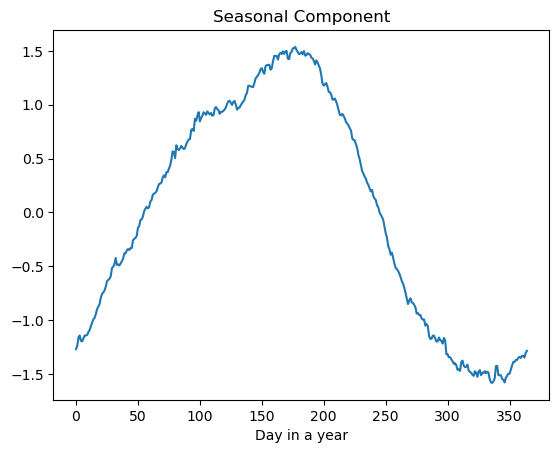

In [18]:
#plot the seasonal component of your time series
plt.plot(season)
plt.xlabel('Day in a year')
plt.title('Seasonal Component')
plt.show()

                Temp
Date                
1996-12-30 -1.142740
1996-12-31 -1.040822
1997-01-01 -1.138082
1997-01-02 -1.035616
1997-01-03 -0.933425
...              ...
2018-07-21  0.596986
2018-07-22  0.698356
2018-07-30  0.899452
2018-07-31  0.900274
2018-08-01  0.901096

[7738 rows x 1 columns]
[-1.26856787 -1.23678705 -1.15951432 ...  0.32646326  0.34429639
  0.32577833]


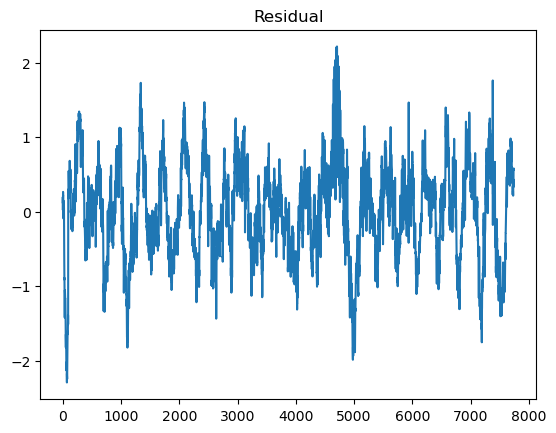

In [19]:
#solve for the time series residual and plot
print(detrend)
print(new_season)
Residual = detrend['Temp'].astype('float') - new_season
plt.plot(np.array(Residual.astype('float')))
plt.title('Residual')
plt.show()

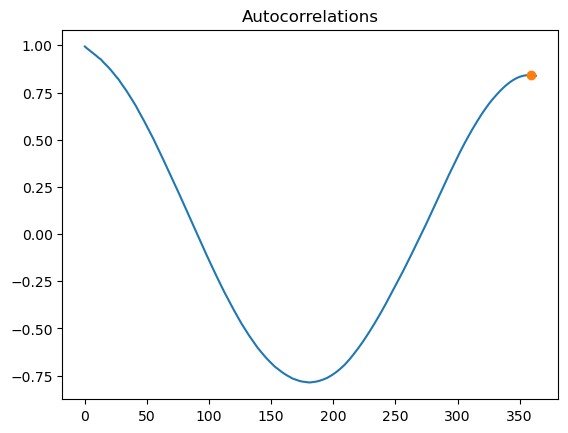

Optimal Periodicity: 359


In [20]:
#plot the autocorrelation of your time series as a function of k
data = [temperature_truncate['Temp'].astype('float').autocorr(lag = k) for k in range(1,365)]
max_index = len(data)//2 +np.argmax(data[len(data)//2:])

plt.plot(data) 
plt.plot(max_index, data[max_index], 'o')
plt.title('Autocorrelations')
plt.show()

print(f'Optimal Periodicity: {max_index}')

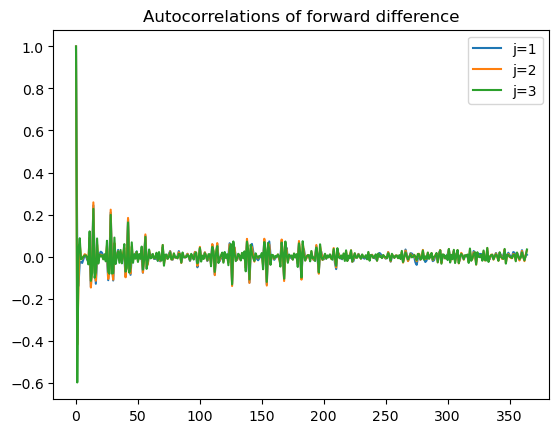

In [21]:
#get the first, second and third order difference quotients
first_diff = Residual.diff(periods = 1)
second_diff = first_diff.diff(periods = 1)
third_diff = second_diff.diff(periods = 1)

#compute the autocorrelation of each time series
auto_cor1 = [first_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor2 = [second_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor3 = [third_diff.astype('float').autocorr(lag = k) for k in range(365)]

#plot the autocorrelation
plt.plot(auto_cor1,label = 'j=1')
plt.plot(auto_cor2,label = 'j=2')
plt.plot(auto_cor3,label = 'j=3')
plt.title('Autocorrelations of forward difference')
plt.legend()

# Classical Decomposition of Coral Coverage

In [23]:
coral = pd.read_csv('coral_dataset.csv', index_col='Date')
coral = coral[coral['percentCover_CTB'] != 'nd'] #drop all of the rows with these entries and then print out the amount of rows in our dataset
coral = coral[coral['percentCover_macroalgae'] != 'nd']
coral = coral[coral['percentCover_allCoral'] != 'nd']

In [24]:
columns_to_cast = ['percentCover_CTB', 'percentCover_macroalgae', 'percentCover_allCoral'] #get a list of the columns that we want to cast
coral[columns_to_cast] = coral[columns_to_cast].astype(float) #cast these columns as floats and divide by 100 to make the percents 
coral[columns_to_cast] = coral[columns_to_cast]/100
coral['percentCover_other'] = 1 - (coral['percentCover_CTB']+coral['percentCover_macroalgae']) #add in another column for other types of coral

In [25]:
# convert the date column to date time objects
coral.index = pd.to_datetime(coral.index)
coral

,site,transect,quadrat,percentCover_allCoral,percentCover_macroalgae,percentCover_CTB,percentCover_other
Date,,,,,,,
1987-12-01,Tektite,1,T1Q1,0.165,0.035,0.060,0.905
1987-12-01,Tektite,1,T1Q2,0.100,0.060,0.740,0.200
1987-12-01,Tektite,1,T1Q3,0.135,0.035,0.450,0.515
1987-12-01,Tektite,1,T1Q4,0.155,0.065,0.615,0.320
1987-12-01,Tektite,1,T1Q5,0.190,0.040,0.480,0.480
...,...,...,...,...,...,...,...
2021-07-01,Yawzi,nd,6,0.000,0.300,0.500,0.200
2021-07-01,Yawzi,nd,7,0.000,0.285,0.455,0.260
2021-07-01,Yawzi,nd,8,0.005,0.350,0.350,0.300


In [28]:
all_coral = coral['percentCover_allCoral']

<Axes: xlabel='Date'>

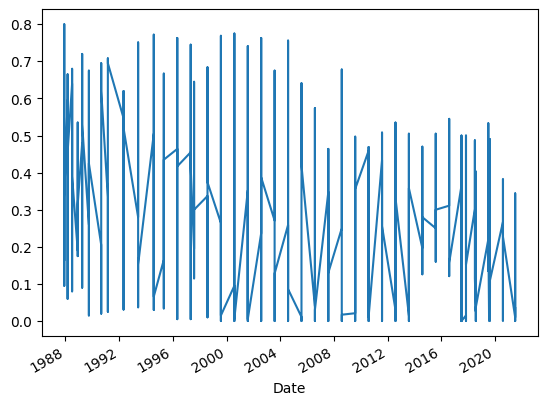

In [31]:
all_coral.plot()

In [97]:
#calculate the moving average
move_average = all_coral.rolling(window = 365).mean()[364:]
move_average

Date
1996-05-01    0.369345
1996-05-01    0.370173
1996-05-01    0.371238
1996-05-01    0.372252
1997-08-01    0.372718
                ...   
2021-07-01    0.062710
2021-07-01    0.062258
2021-07-01    0.061915
2021-07-01    0.061929
2021-07-01    0.062025
Name: percentCover_allCoral, Length: 1900, dtype: float64

In [98]:
#calculate the detrended time series
detrend_coral = all_coral[366:] - move_average
detrend_coral

Date
1987-12-01    0.279521
1987-12-01    0.280170
1987-12-01    0.278822
1987-12-01    0.278003
1987-12-01    0.278000
                ...   
2021-07-01   -0.027710
2021-07-01   -0.027258
2021-07-01   -0.026915
2021-07-01   -0.026929
2021-07-01   -0.027025
Name: percentCover_allCoral, Length: 90794, dtype: float64

In [99]:
#calculate the seasonal component of the time series
season = np.zeros(365) 
for k in range(365):
    season[k] = detrend_coral[k::365].mean()
#extend the period to 365 days
new_season = np.tile(season, len(all_coral[364:])//len(season)+1)[:len(all_coral[364:])]

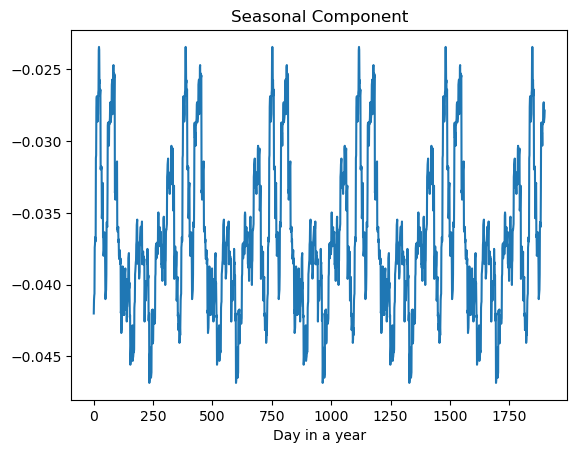

In [100]:
#plot the seasonal component of your time series
plt.plot(new_season)
plt.xlabel('Day in a year')

plt.title('Seasonal Component')
plt.show()

In [101]:
#solve for the time series residual and plot
print(detrend_coral)
print(new_season)
Residual = detrend_coral.astype('float') - new_season
plt.plot(np.array(Residual.astype('float')))
plt.title('Residual')
plt.show()

Date
1987-12-01    0.279521
1987-12-01    0.280170
1987-12-01    0.278822
1987-12-01    0.278003
1987-12-01    0.278000
                ...   
2021-07-01   -0.027710
2021-07-01   -0.027258
2021-07-01   -0.026915
2021-07-01   -0.026929
2021-07-01   -0.027025
Name: percentCover_allCoral, Length: 90794, dtype: float64
[-0.04201116 -0.04106483 -0.04077451 ... -0.02846933 -0.02833661
 -0.02787458]


ValueError: operands could not be broadcast together with shapes (90794,) (1900,) 

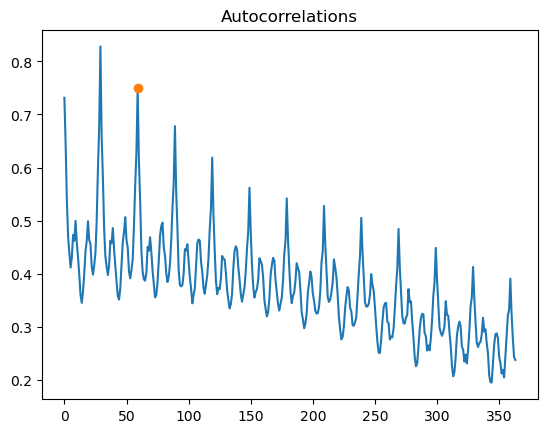

Optimal Periodicity: 59


In [102]:
#plot the autocorrelation of your time series as a function of k
data = [all_coral.astype('float').autocorr(lag = k) for k in range(1,365)]
max_index = 45 +np.argmax(data[45:])

plt.plot(data) 
plt.plot(max_index, data[max_index], 'o')
plt.title('Autocorrelations')
plt.show()

print(f'Optimal Periodicity: {max_index}')

In [69]:
all_coral = all_coral.sort_index()
all_coral

Date
1987-12-01    0.165
1987-12-01    0.800
1987-12-01    0.670
1987-12-01    0.481
1987-12-01    0.589
              ...  
2021-07-01    0.149
2021-07-01    0.144
2021-07-01    0.267
2021-07-01    0.150
2021-07-01    0.035
Name: percentCover_allCoral, Length: 2264, dtype: float64

In [33]:
#all_coral_yawzi
all_coral_tekite = coral[coral['site'] == 'Tektite']
all_coral_tekite = all_coral_tekite['percentCover_allCoral']
all_coral_tekite.astype('float')

all_coral_yawzi = coral[coral['site'] == 'Yawzi']
all_coral_yawzi = all_coral_yawzi['percentCover_allCoral']
all_coral_yawzi.astype('float')

Date
1987-12-01    0.570
1987-12-01    0.230
1987-12-01    0.800
1987-12-01    0.670
1987-12-01    0.481
              ...  
2021-07-01    0.000
2021-07-01    0.000
2021-07-01    0.005
2021-07-01    0.005
2021-07-01    0.035
Name: percentCover_allCoral, Length: 1116, dtype: float64

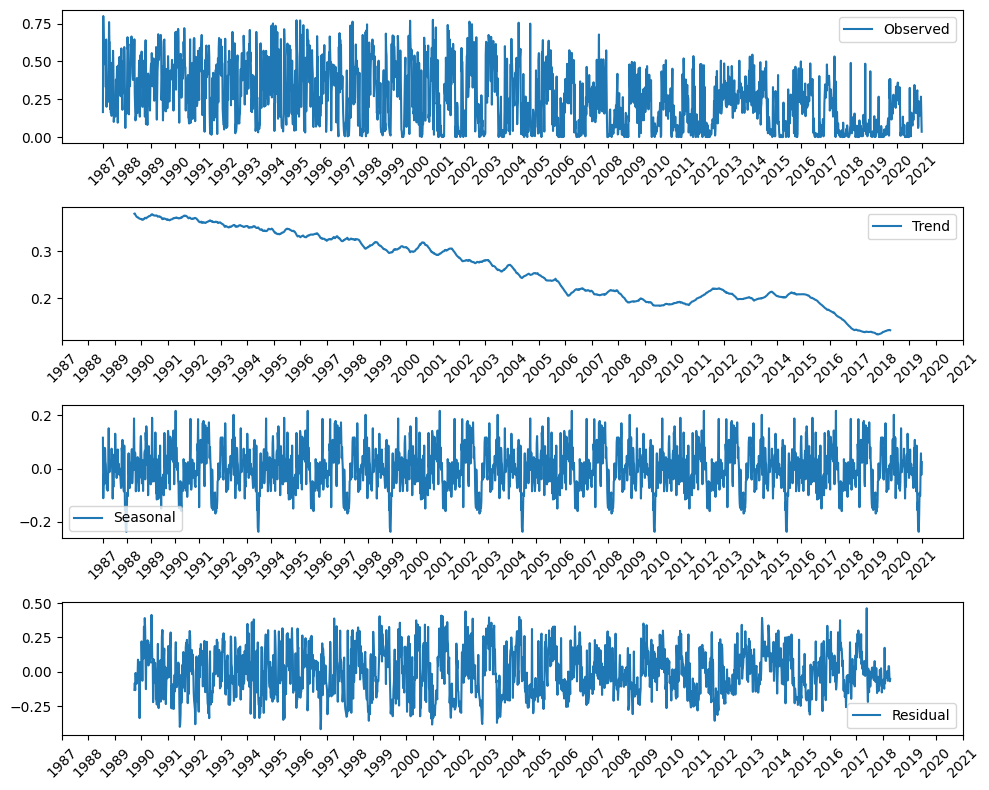

In [71]:
trends_coral = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 365)
# Sample DataFrame with date index
date_range = pd.date_range(start='1987-12-01', periods=2264, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends_coral.observed, label='Observed')
# Set x-axis ticks at the beginning of each year
plt.xticks(year_indices, years, rotation = 45)
plt.legend()

plt.subplot(412)
plt.plot(trends_coral.trend, label='Trend')
# Set x-axis ticks at the beginning of each year
plt.xticks(year_indices, years, rotation = 45)
plt.legend()

plt.subplot(413)
plt.plot(trends_coral.seasonal, label='Seasonal')
# Set x-axis ticks at the beginning of each year
plt.xticks(year_indices, years, rotation = 45)
plt.legend()

plt.subplot(414)
plt.plot(trends_coral.resid, label='Residual')
# Set x-axis ticks at the beginning of each year
plt.xticks(year_indices, years, rotation = 45)
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
trends_coral.observed

array([0.165, 0.8  , 0.67 , ..., 0.267, 0.15 , 0.035])

[nan nan nan ... nan nan nan]


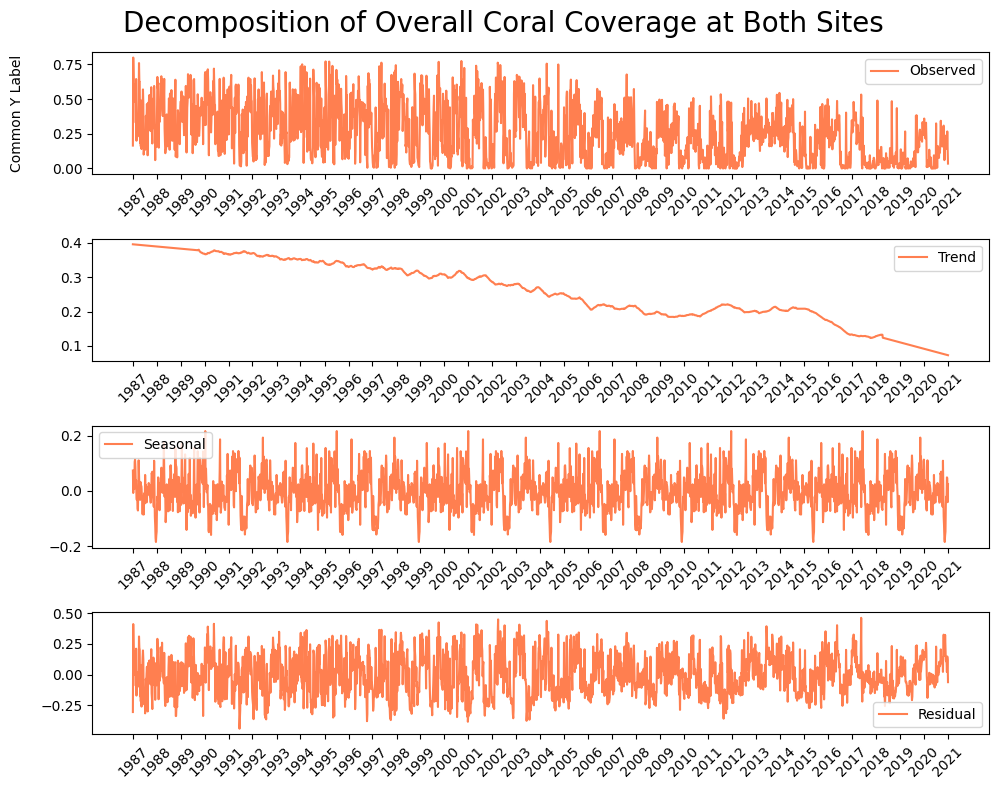

In [115]:
trends = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 365, extrapolate_trend='freq')

date_range = pd.date_range(start='1987-12-01', periods=2264, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
# plt.ylabel('Percent Coral Cov.')
plt.ylabel('Common Y Label', labelpad=20)
# plt.xlabel('Years')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
# plt.ylabel('Percent Coral Cov.')
# plt.xlabel('Years')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
# plt.ylabel('Percent Coral Cov.')
# plt.xlabel('Years')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
# plt.ylabel('Percent Coral Cov.')
# plt.xlabel('Years')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Both Sites', fontsize = 20)
#plt.subxlabel('common x')

# Adjust subplot layout to center ylabel
plt.subplots_adjust(left=0.5, bottom=0.5, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.tight_layout()

plt.savefig('Overall_decomp.png')
plt.show()

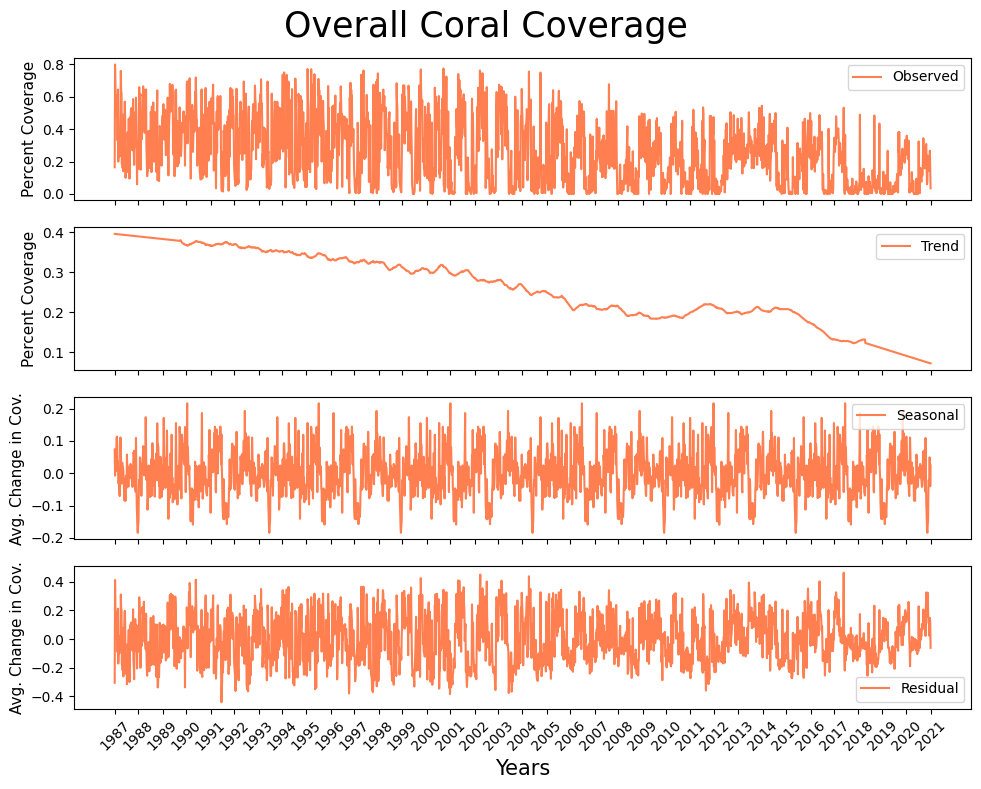

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'all_coral.sort_index().values' is defined elsewhere and contains the data
# Decompose the data
trends = seasonal_decompose(all_coral.sort_index().values, model='additive', period=365, extrapolate_trend='freq')

# Generate a date range for the x-axis
date_range = pd.date_range(start='1987-12-01', periods=2264, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex='col')  # 4 rows, 1 column, shared x-axis

# Plot each component
axes[0].plot(trends.observed, label='Observed', color='coral')
axes[0].set_ylabel('Percent Coverage', fontsize = 11)
axes[0].legend()

axes[1].plot(trends.trend, label='Trend', color='coral')
axes[1].set_ylabel('Percent Coverage', fontsize = 11)
axes[1].legend()

axes[2].plot(trends.seasonal, label='Seasonal', color='coral')
axes[2].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[2].legend()

axes[3].plot(trends.resid, label='Residual', color='coral')
axes[3].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[3].legend()

# Set common x-axis properties
for ax in axes:
    ax.set_xticks(year_indices)
    ax.set_xticklabels(years, rotation=45)

# Add a super title
fig.suptitle('Overall Coral Coverage', fontsize=25)

# Set a common Y-Axis label
#fig.text(0.01, 0.5, 'Percent Coral Coverage', va='center', ha='center', rotation='vertical', fontsize=15)
plt.xlabel('Years', fontsize = 15)

# Optional: Adjust the layout
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, hspace=0.5)
plt.tight_layout()

# Save the figure
plt.savefig('Overall_decomp.png')

# Show the plot
plt.show()


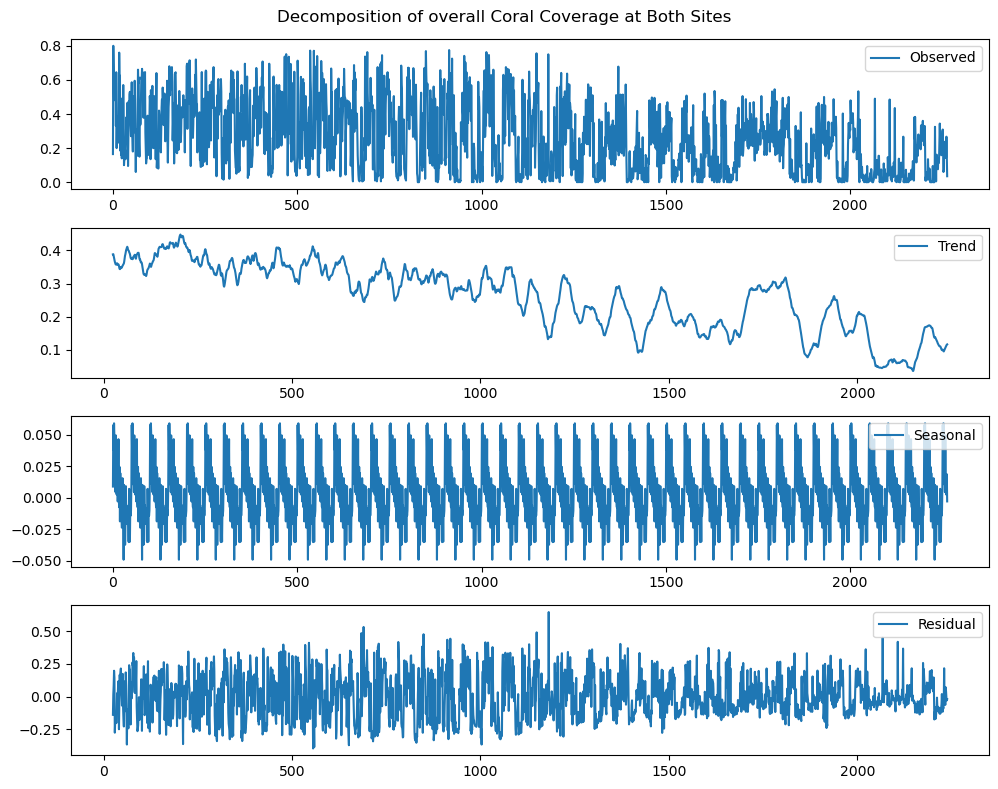

In [121]:
trends = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 50)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.suptitle('Decomposition of overall Coral Coverage at Both Sites')
plt.tight_layout()
plt.show()

In [76]:
all_coral_yawzi.sort_index()

Date
1987-12-01    0.570
1987-12-01    0.420
1987-12-01    0.225
1987-12-01    0.140
1987-12-01    0.490
              ...  
2021-07-01    0.060
2021-07-01    0.015
2021-07-01    0.325
2021-07-01    0.045
2021-07-01    0.035
Name: percentCover_allCoral, Length: 1116, dtype: float64

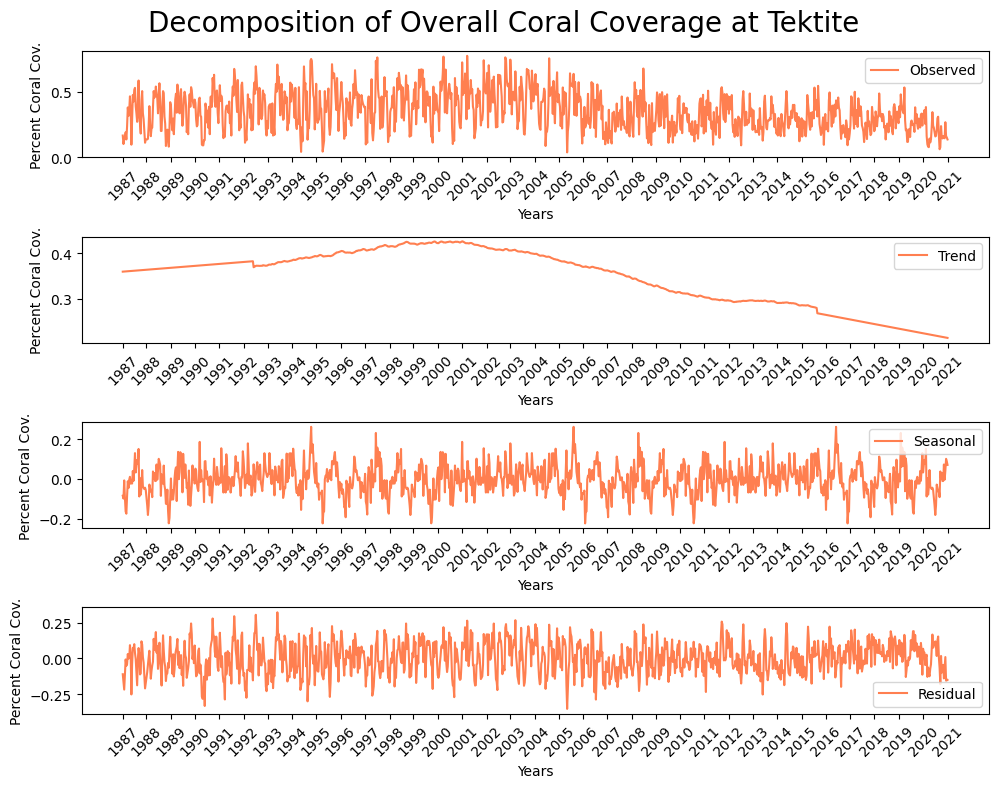

In [108]:
trends = seasonal_decompose(all_coral_tekite.sort_index().values, model = 'additive', period = 365, extrapolate_trend='freq')

date_range = pd.date_range(start='1987-12-01', periods=1148, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)


plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Tektite', fontsize = 20)
plt.tight_layout()

plt.savefig('Tektite_decompp.png')
plt.show()

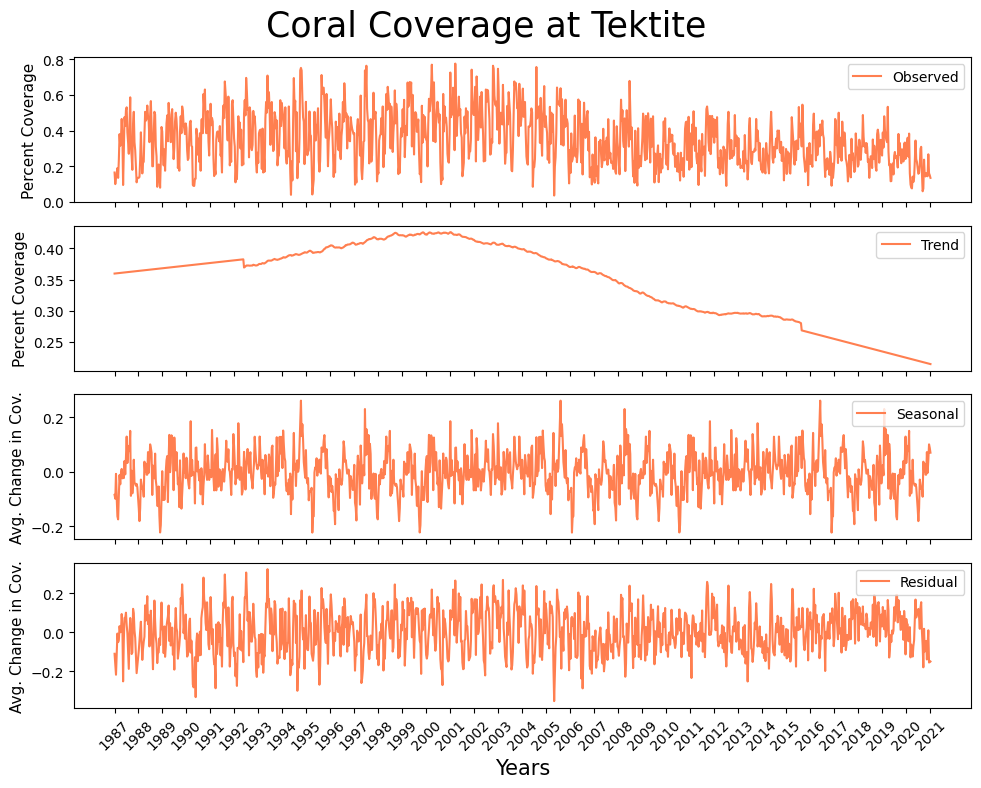

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'all_coral_tekite.sort_index().values' is defined elsewhere and contains the data
# Decompose the data
trends = seasonal_decompose(all_coral_tekite.sort_index().values, model='additive', period=365, extrapolate_trend='freq')

# Generate a date range for the x-axis
date_range = pd.date_range(start='1987-12-01', periods=1148, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)  # 4 rows, 1 column, shared x-axis

# Plot each component
axes[0].plot(trends.observed, label='Observed', color='coral')
axes[0].set_ylabel('Percent Coverage', fontsize = 11)
axes[0].legend()

axes[1].plot(trends.trend, label='Trend', color='coral')
axes[1].set_ylabel('Percent Coverage', fontsize = 11)
axes[1].legend()

axes[2].plot(trends.seasonal, label='Seasonal', color='coral')
axes[2].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[2].legend()

axes[3].plot(trends.resid, label='Residual', color='coral')
axes[3].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[3].legend()

# Set common x-axis properties
for ax in axes:
    ax.set_xticks(year_indices)
    ax.set_xticklabels(years, rotation=45)

# Add a super title
fig.suptitle('Coral Coverage at Tektite', fontsize=25)

# Set a common Y-Axis label
#fig.text(0.01, 0.5, 'Percent Coral Coverage', va='center', ha='center', rotation='vertical', fontsize=15)
plt.xlabel('Years', fontsize = 15)

# Optional: Adjust the layout
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.9, top=0.9, hspace=0.5)
plt.tight_layout()

# Save the figure
plt.savefig('Tektite_decomp.png')

# Show the plot
plt.show()


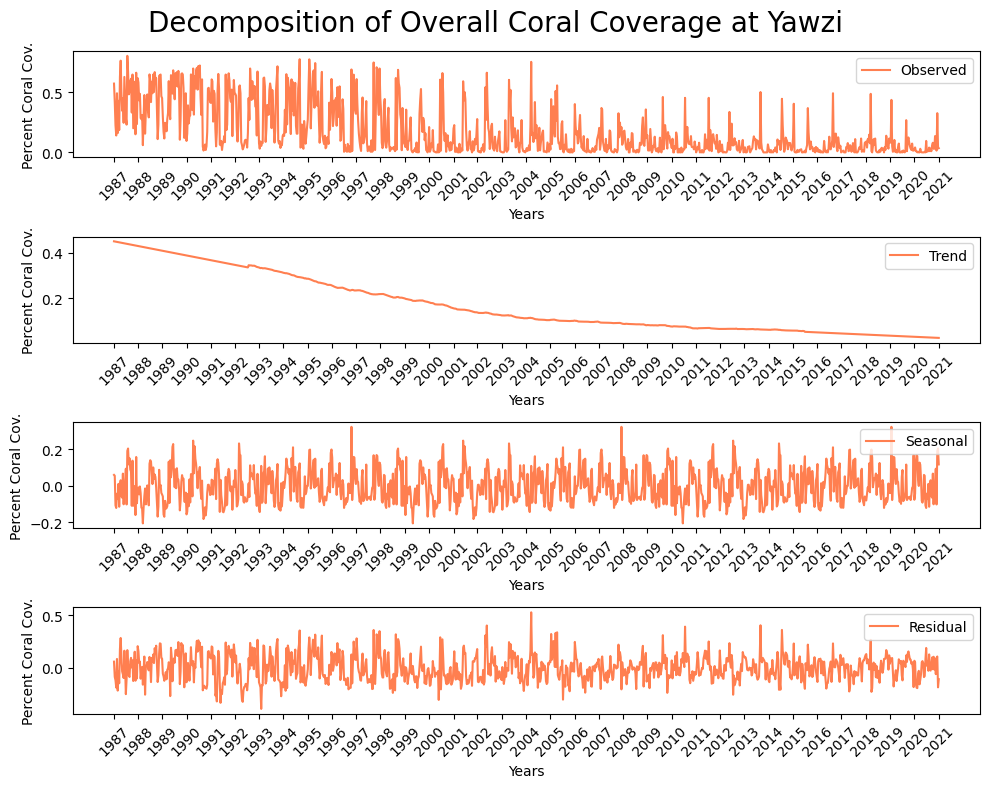

In [109]:
trends = seasonal_decompose(all_coral_yawzi.sort_index().values, model = 'additive', period = 365, extrapolate_trend='freq')

date_range = pd.date_range(start='1987-12-01', periods=1116, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.xticks(year_indices, years, rotation = 45)
plt.ylabel('Percent Coral Cov.')
plt.xlabel('Years')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Yawzi', fontsize = 20)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Yawzi_decomp.png')
plt.show()

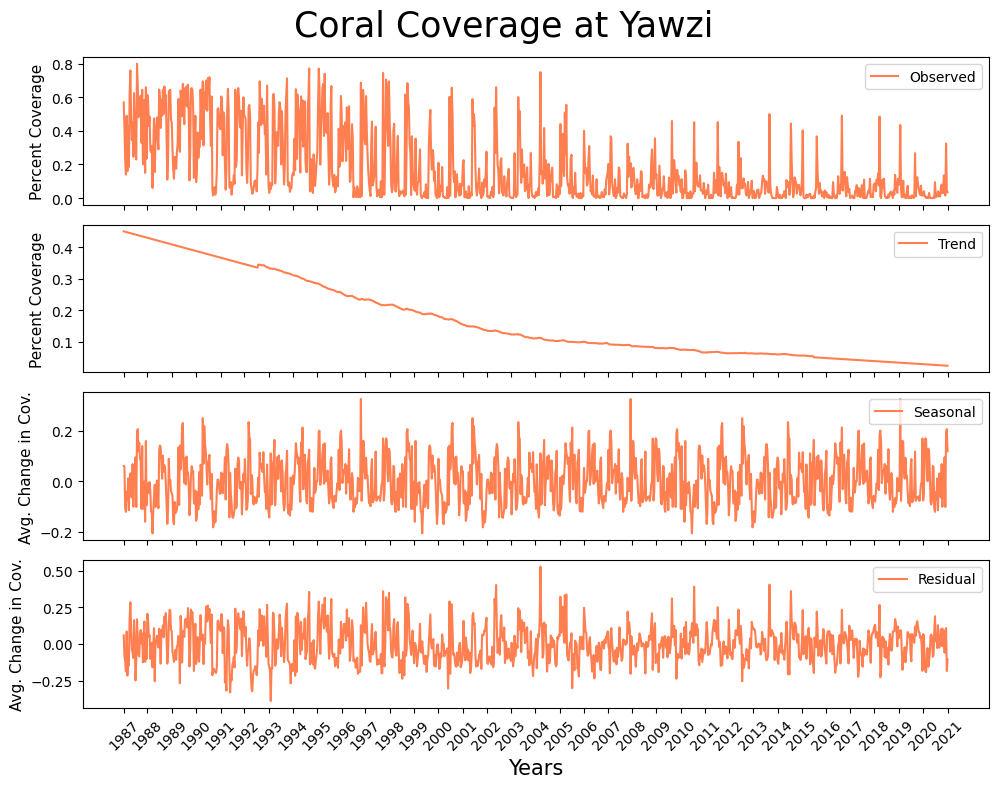

In [142]:
# Assuming 'all_coral_yawzi.sort_index().values' is defined elsewhere and contains the data
# Decompose the data
trends = seasonal_decompose(all_coral_yawzi.sort_index().values, model='additive', period=365, extrapolate_trend='freq')

# Generate a date range for the x-axis
date_range = pd.date_range(start='1987-12-01', periods=1116, freq='D')
# Calculate indices for each year
start_year = 1987
end_year = 2021
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)  # 4 rows, 1 column, shared x-axis

# Plot each component
axes[0].plot(trends.observed, label='Observed', color='coral')
axes[0].set_ylabel('Percent Coverage', fontsize = 11)
axes[0].legend()

axes[1].plot(trends.trend, label='Trend', color='coral')
axes[1].set_ylabel('Percent Coverage', fontsize = 11)
axes[1].legend()

axes[2].plot(trends.seasonal, label='Seasonal', color='coral')
axes[2].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[2].legend()

axes[3].plot(trends.resid, label='Residual', color='coral')
axes[3].set_ylabel('Avg. Change in Cov.', fontsize = 11)
axes[3].legend()

# Set common x-axis properties
for ax in axes:
    ax.set_xticks(year_indices)
    ax.set_xticklabels(years, rotation=45)

# Add a super title
fig.suptitle('Coral Coverage at Yawzi', fontsize=25)

# Set a common Y-Axis label
#fig.text(0.01, 0.5, 'Percent Coral Coverage', va='center', ha='center', rotation='vertical', fontsize=15)
plt.xlabel('Years', fontsize = 15)
# Optional: Adjust the layout
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, hspace=0.5)
plt.tight_layout()

# Save the figure
plt.savefig('Yawzi_decomp.png')

# Show the plot
plt.show()


In [45]:
sea_df = pd.read_csv("seawatertemp (1).csv", index_col = "Date") #read in the dataset 
sea_df.index = pd.to_datetime(sea_df.index)
sea_df['year_column'] = sea_df.index.year
sea_df = sea_df[sea_df['Site'].isin(['Yawzi_NPS','Yawzi_9m'])]
specific_value_count = sea_df['Temperature'].value_counts()['nd']
# print(specific_value_count)
sea_df = sea_df[sea_df['Temperature'] != 'nd']
sea_df['Temperature'] = sea_df['Temperature'].astype(float)
avg_sea_temp = sea_df.groupby('year_column')['Temperature'].mean()
avg_sea_temp

year_column
1989    27.153627
1990    27.421425
1991    27.324986
1992    27.485410
1993    27.564384
1994    27.395973
1995    27.806966
1996    27.342350
1997    27.808127
1998    28.170986
1999    27.994685
2000    27.482548
2001    27.725918
2002    27.691342
2003    27.361349
2004    28.469801
2005    28.213955
2006    28.030083
2007    28.029944
2008    27.474306
2009    27.650138
2010    28.339280
2011    27.727008
2012    27.858338
2013    27.045025
2014    28.770303
2015    28.070670
2016    27.617150
Name: Temperature, dtype: float64

<Axes: xlabel='year_column'>

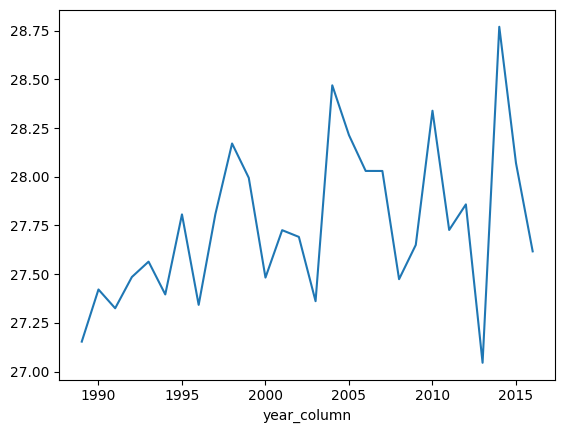

In [46]:
avg_sea_temp.plot()

In [48]:
sea_temp_trends = seasonal_decompose(avg_sea_temp, model = 'additive', period = 1)

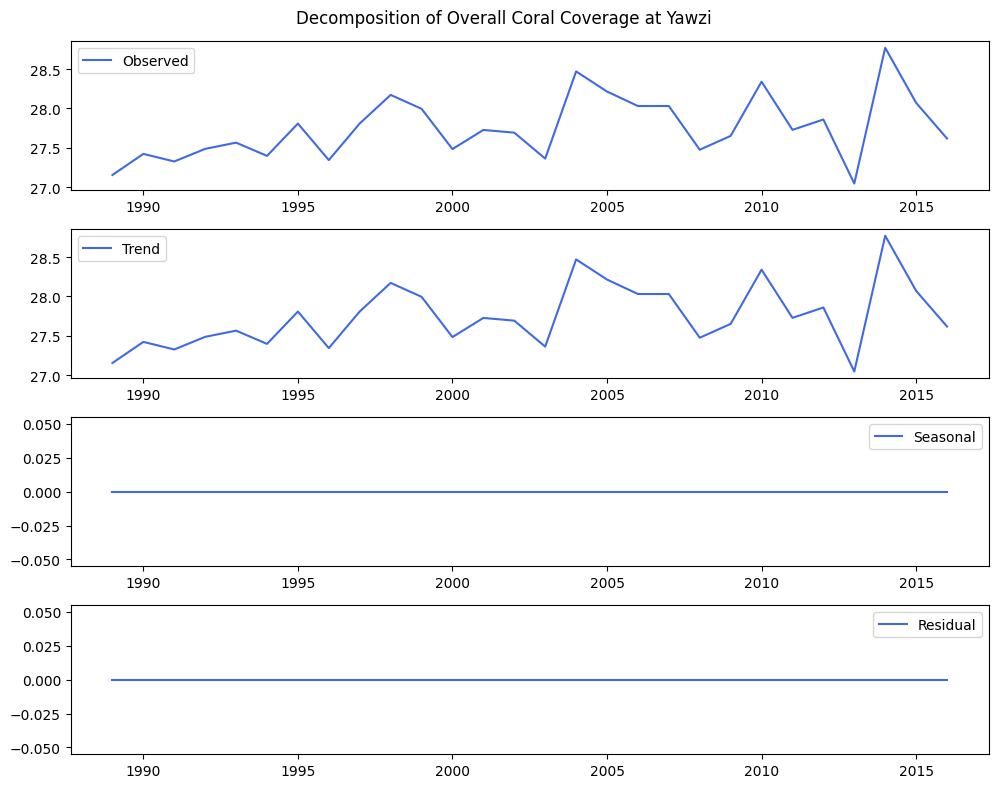

In [49]:
# Plot the individual components
# Sample pandas dataset with years from 1989 to 2016
#years = pd.date_range(start='1989-01-01', end='2016-12-31', freq='YS')

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(sea_temp_trends.observed, label='Observed', color = 'royalblue')
plt.legend()

plt.subplot(412)
plt.plot(sea_temp_trends.trend, label='Trend', color = 'royalblue')
plt.legend()

plt.subplot(413)
plt.plot(sea_temp_trends.seasonal, label='Seasonal', color = 'royalblue')
plt.legend()

plt.subplot(414)
plt.plot(sea_temp_trends.resid, label='Residual', color = 'royalblue')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Yawzi')
plt.tight_layout()

#Save the plot as a PNG file
#plt.savefig('new_sea_water.png')
plt.show()

In [7]:
sea_df = pd.read_csv("seawatertemp (1).csv", index_col = "Date") #read in the dataset 

In [8]:
sea_df = sea_df[sea_df['Site'].isin(['Yawzi_NPS','Yawzi_9m'])]

In [41]:
specific_value_count = sea_df['Temperature'].value_counts()['nd']
sea_df = sea_df[sea_df['Temperature'] != 'nd']
sea_df['Temperature'] = sea_df['Temperature'].astype(float)

KeyError: 'nd'

[Timestamp('1989-01-10 00:00:00'),
 Timestamp('1989-01-11 00:00:00'),
 Timestamp('1989-01-12 00:00:00'),
 Timestamp('1989-01-13 00:00:00'),
 Timestamp('1989-01-14 00:00:00'),
 Timestamp('1989-01-15 00:00:00'),
 Timestamp('1989-01-16 00:00:00'),
 Timestamp('1989-01-17 00:00:00'),
 Timestamp('1989-01-18 00:00:00'),
 Timestamp('1989-01-19 00:00:00'),
 Timestamp('1989-01-20 00:00:00'),
 Timestamp('1989-01-21 00:00:00'),
 Timestamp('1989-01-22 00:00:00'),
 Timestamp('1989-01-23 00:00:00'),
 Timestamp('1989-01-24 00:00:00'),
 Timestamp('1989-01-25 00:00:00'),
 Timestamp('1989-01-26 00:00:00'),
 Timestamp('1989-01-27 00:00:00'),
 Timestamp('1989-01-28 00:00:00'),
 Timestamp('1989-01-29 00:00:00'),
 Timestamp('1989-01-30 00:00:00'),
 Timestamp('1989-01-31 00:00:00'),
 Timestamp('1989-02-01 00:00:00'),
 Timestamp('1989-02-02 00:00:00'),
 Timestamp('1989-02-03 00:00:00'),
 Timestamp('1989-02-04 00:00:00'),
 Timestamp('1989-02-05 00:00:00'),
 Timestamp('1989-02-06 00:00:00'),
 Timestamp('1989-02-

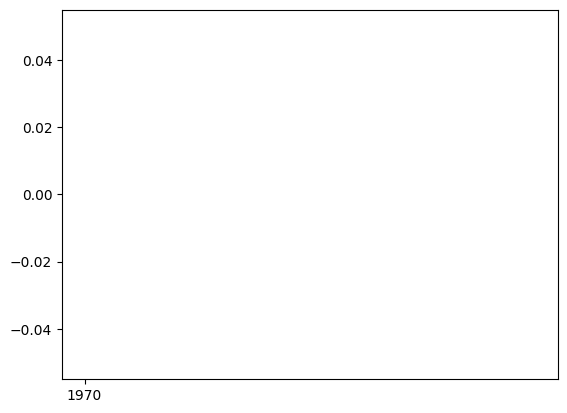

In [58]:
sea_df['Temperature'] = sea_df['Temperature'].astype(float)
sea_df_new = sea_df['Temperature']
a = sea_df_new.index
a
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')

ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()

dates = [date for date in a]
dates

In [50]:
sea_temp_trends = seasonal_decompose(sea_df_new.values, model = 'additive', period = 365)


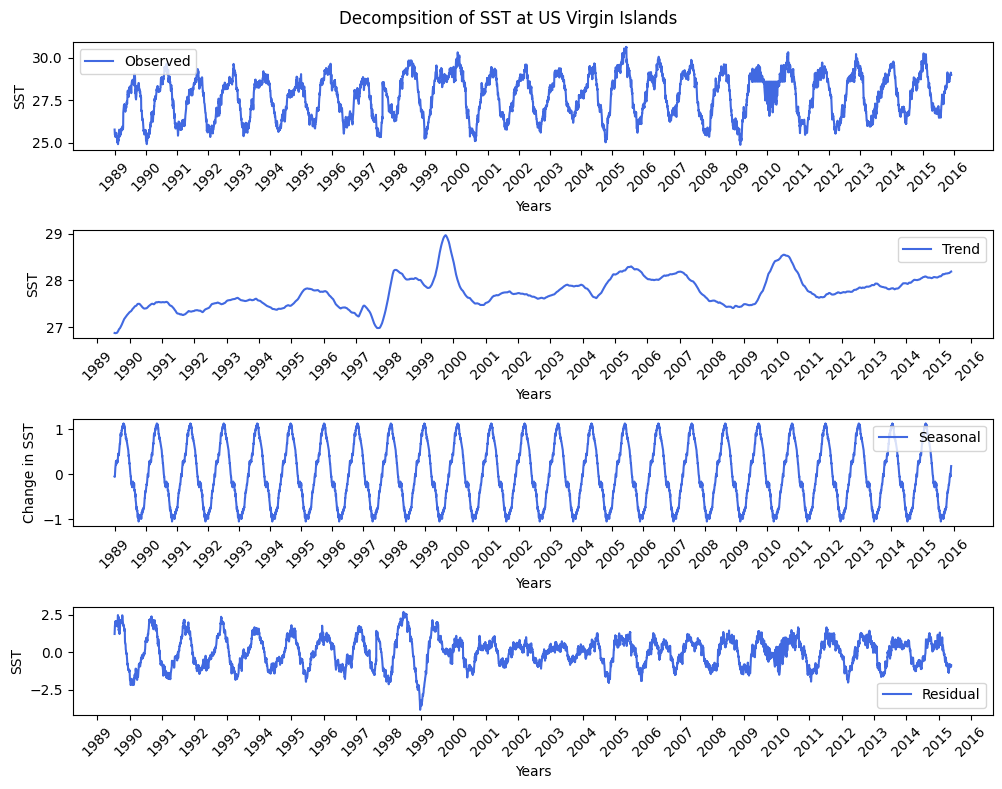

In [67]:
# Plot the individual components
# Sample pandas dataset with years from 1989 to 2016
#years = pd.date_range(start='1989-01-01', end='2016-12-31', freq='YS')
date_range = pd.date_range(start='1989-01-01', periods=9163, freq='D')
# Calculate indices for each year
start_year = 1989
end_year = 2016
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)



plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(sea_temp_trends.observed, label='Observed', color = 'royalblue')
# Set x-axis ticks at the beginning of each year
plt.xticks(year_indices, years, rotation = 45)
plt.xlabel('Years')
plt.ylabel('SST')
plt.legend()

plt.subplot(412)
plt.plot(sea_temp_trends.trend, label='Trend', color = 'royalblue')
plt.xticks(year_indices, years, rotation = 45)
plt.xlabel('Years')
plt.ylabel('SST')
plt.legend()

plt.subplot(413)
plt.plot(sea_temp_trends.seasonal, label='Seasonal', color = 'royalblue')
plt.xticks(year_indices, years, rotation = 45)
plt.xlabel('Years')
plt.ylabel('Change in SST')
plt.legend()

plt.subplot(414)
plt.plot(sea_temp_trends.resid, label='Residual', color = 'royalblue')
plt.xticks(year_indices, years, rotation = 45)
plt.xlabel('Years')
plt.ylabel('SST')
plt.legend()

plt.suptitle('SST at US Virgin Islands', fontsize = 25)
plt.tight_layout()

#Save the plot as a PNG file
plt.savefig('new_sea_water.png')
plt.show()

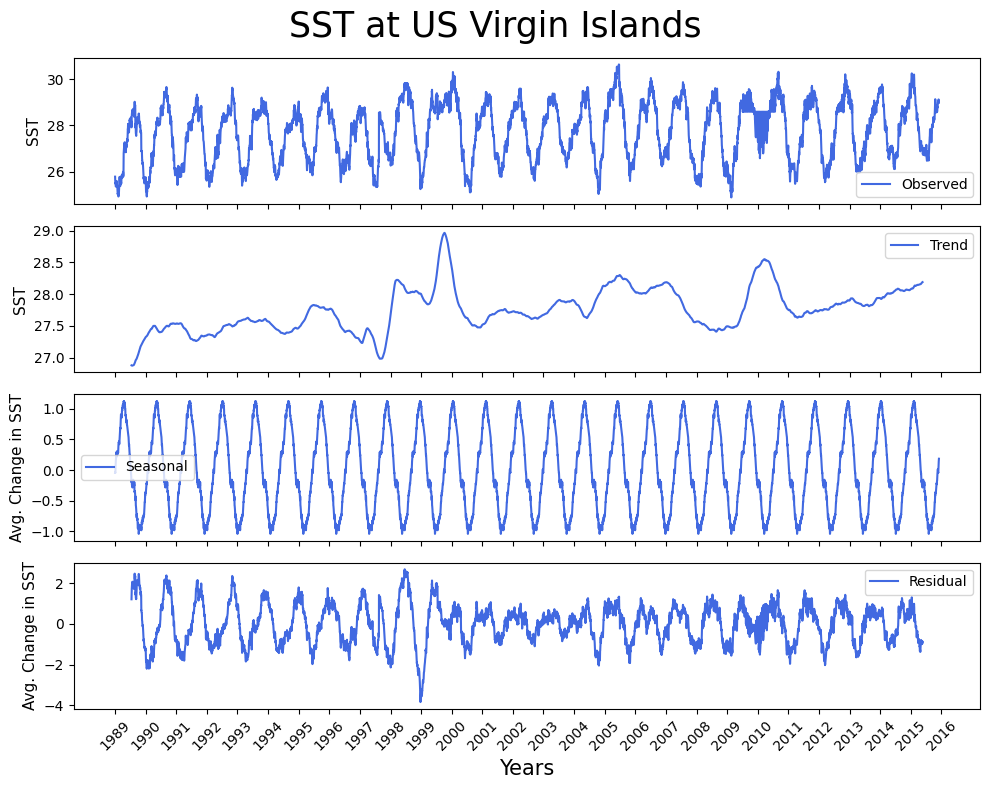

In [141]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'sea_temp_trends' is defined elsewhere and contains the data

# Generate a date range for the x-axis
date_range = pd.date_range(start='1989-01-01', periods=9163, freq='D')
# Calculate indices for each year
start_year = 1989
end_year = 2016
years = range(start_year, end_year + 1)
year_indices = np.linspace(0, len(date_range) - 1, num=len(years), dtype=int)

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)  # 4 rows, 1 column, shared x-axis

# Plot each component
axes[0].plot(sea_temp_trends.observed, label='Observed', color='royalblue')
axes[0].set_ylabel('SST', fontsize = 11)
axes[0].legend()

axes[1].plot(sea_temp_trends.trend, label='Trend', color='royalblue')
axes[1].set_ylabel('SST', fontsize = 11)
axes[1].legend()

axes[2].plot(sea_temp_trends.seasonal, label='Seasonal', color='royalblue')
axes[2].set_ylabel('Avg. Change in SST', fontsize = 11)
axes[2].legend()

axes[3].plot(sea_temp_trends.resid, label='Residual', color='royalblue')
axes[3].set_ylabel('Avg. Change in SST', fontsize = 11)
axes[3].legend()

# Set common x-axis properties
for ax in axes:
    ax.set_xticks(year_indices)
    ax.set_xticklabels(years, rotation=45)

# Add a super title
fig.suptitle('SST at US Virgin Islands', fontsize=25)

# Optional: Adjust the layout
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.9, top=0.9, hspace=0.5)
plt.xlabel('Years', fontsize = 15)
plt.tight_layout()

# Save the figure
plt.savefig('new_sea_water.png')

# Show the plot
plt.show()
